## Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

## Read the data

In [2]:
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, 'data', 'raw', 'customer_churn_dataset-training-master.csv')
test_data_dir = os.path.join(project_dir, 'data', 'raw', 'customer_churn_dataset_testing-master.csv')

In [3]:
df = pd.read_csv(data_dir)

In [4]:
df.head(20)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
5,8.0,51.0,Male,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0
6,9.0,58.0,Female,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0
7,10.0,55.0,Female,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0
8,11.0,39.0,Male,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0
9,12.0,64.0,Female,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0


In [5]:
print(df.isna().sum())

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


In [6]:
df.dropna(inplace=True)

Convert data types

In [7]:
int_cols = ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
for col in int_cols:
    df[col] = df[col].astype('int64')

categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   CustomerID         440832 non-null  int64   
 1   Age                440832 non-null  int64   
 2   Gender             440832 non-null  category
 3   Tenure             440832 non-null  int64   
 4   Usage Frequency    440832 non-null  int64   
 5   Support Calls      440832 non-null  int64   
 6   Payment Delay      440832 non-null  int64   
 7   Subscription Type  440832 non-null  category
 8   Contract Length    440832 non-null  category
 9   Total Spend        440832 non-null  int64   
 10  Last Interaction   440832 non-null  int64   
 11  Churn              440832 non-null  int64   
dtypes: category(3), int64(9)
memory usage: 34.9 MB


In [9]:
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.344771,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.722712,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


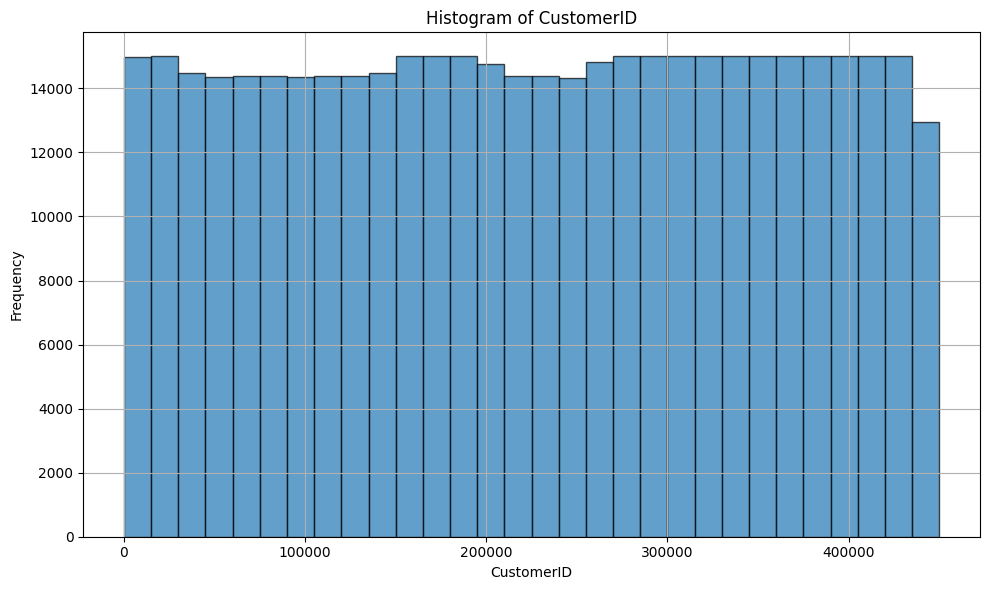

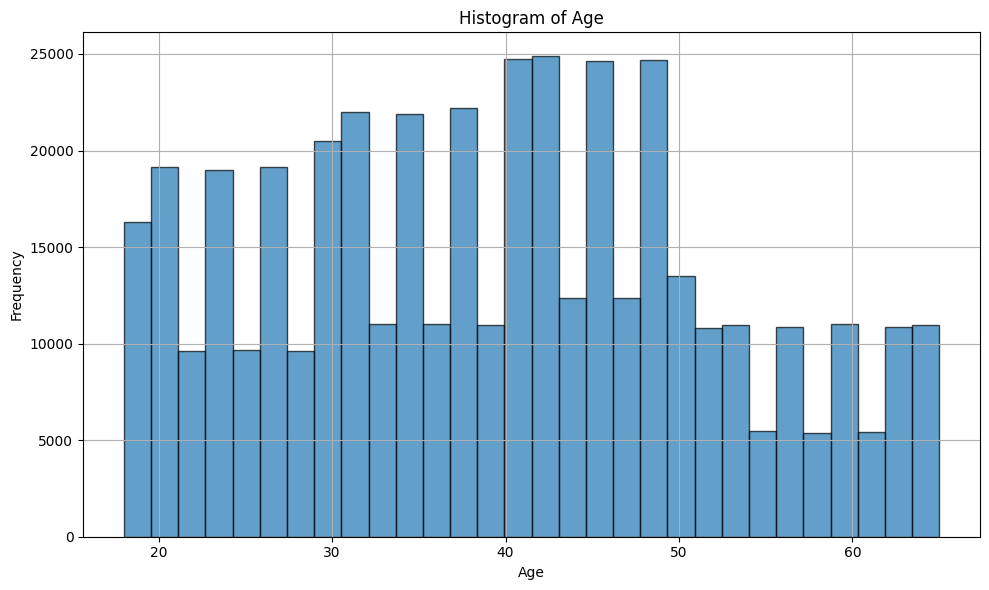

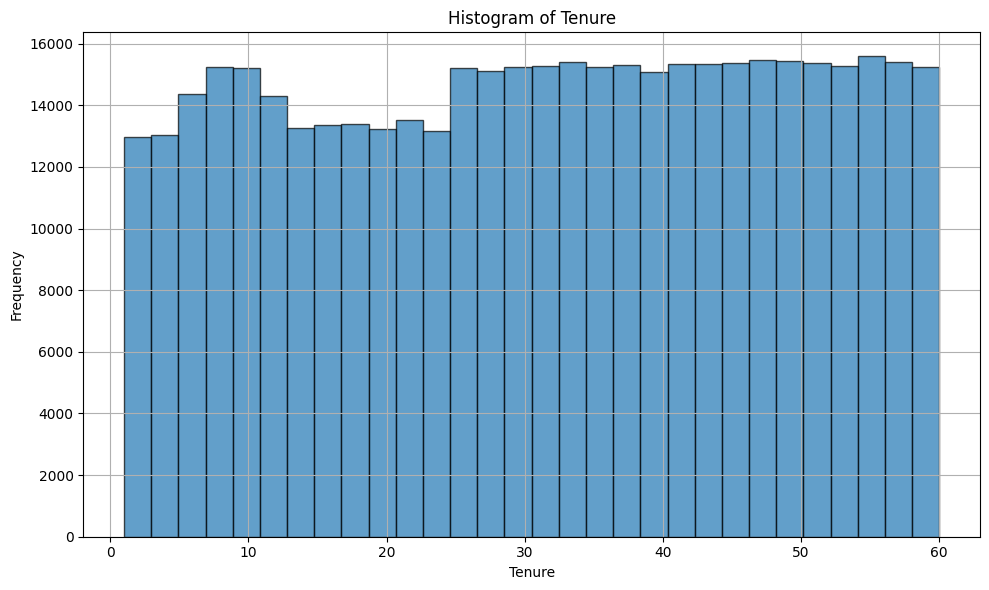

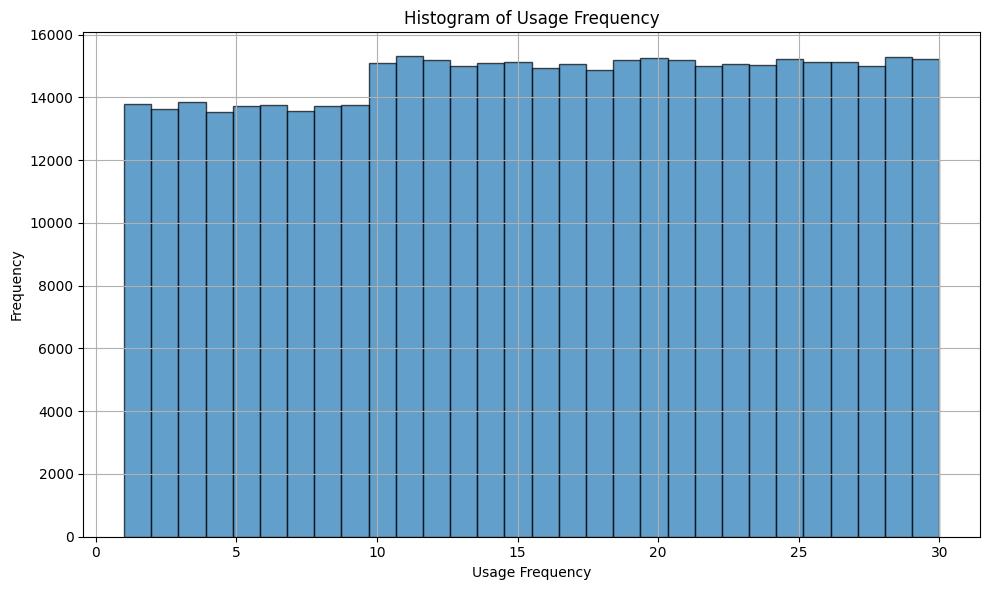

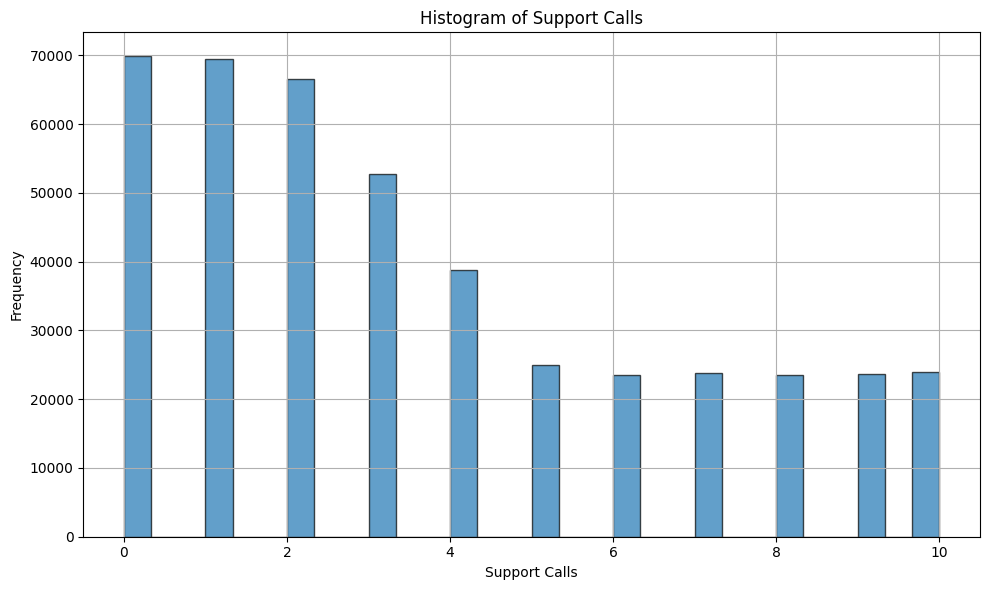

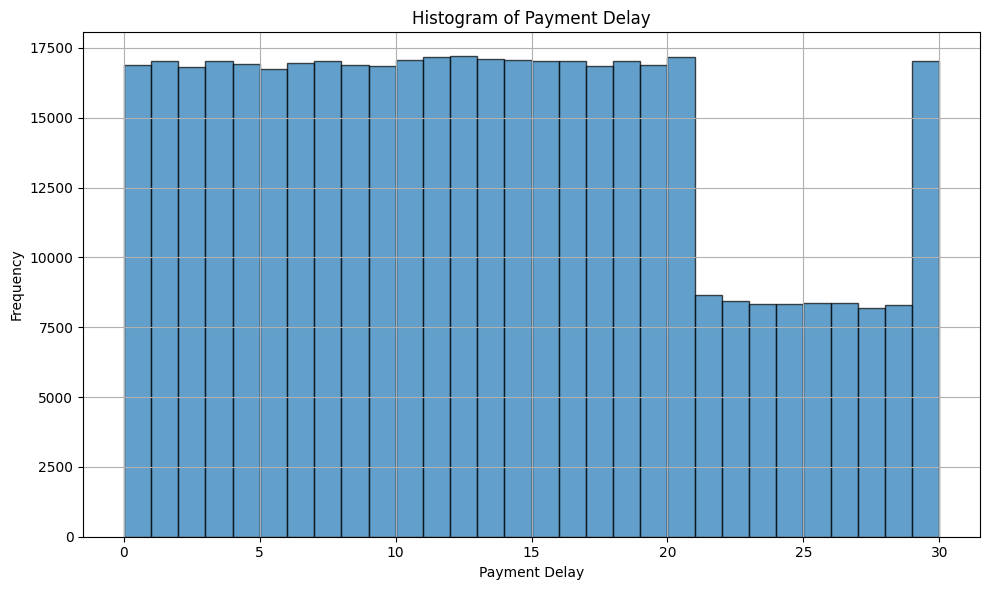

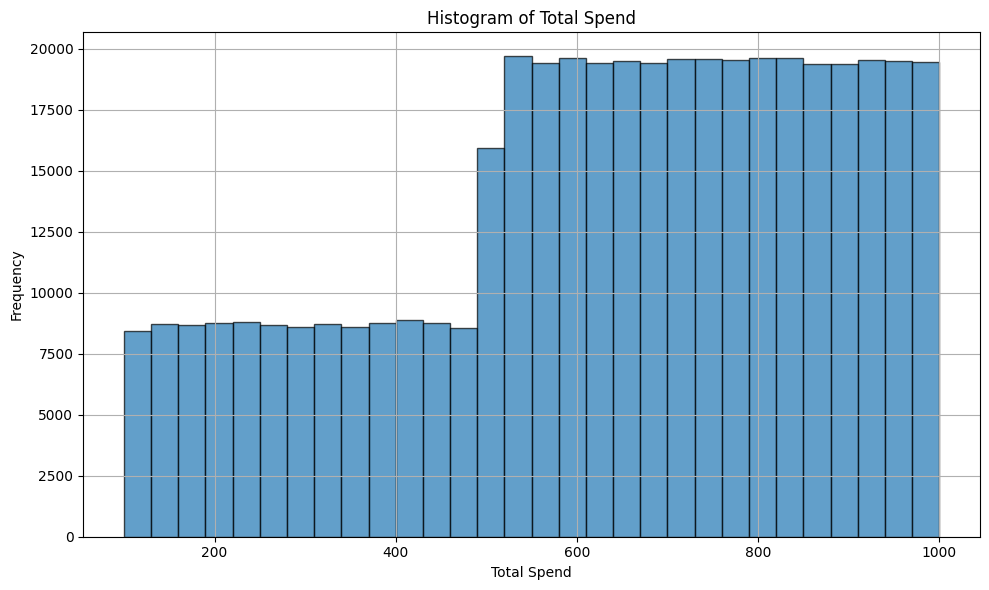

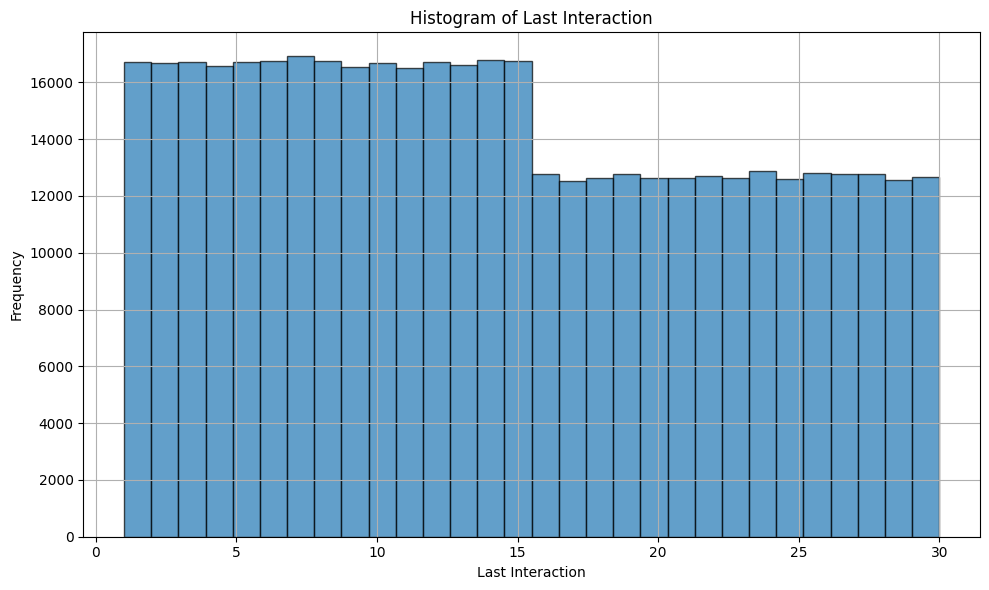

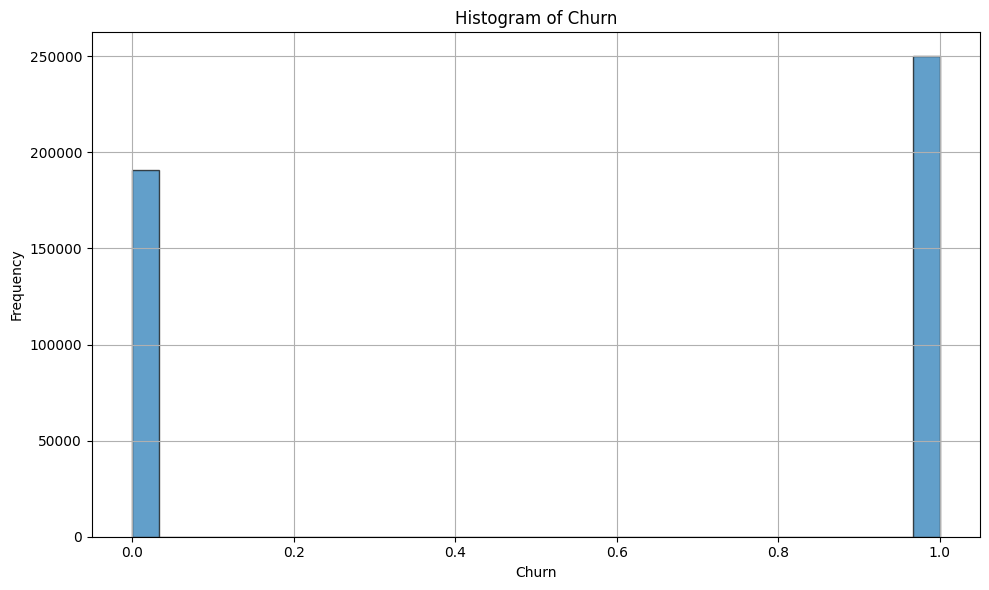

In [ ]:
columns = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
for column in columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()